<a href="https://colab.research.google.com/github/KuriKosho/DeepLearning/blob/main/unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts.

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input.

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [5]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  # Hàm này tạo ra một generator, cung cấp dữ liệu cho mô hình theo từng batch.
  # files: Danh sách các tên file ảnh.
  # batch_size: Kích thước của mỗi batch (mặc định là 32).
  # sz: Kích thước ảnh đầu ra (mặc định là 256x256).

  while True:
    # Vòng lặp vô hạn để tạo ra các batch liên tục.

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)
    # Lấy ngẫu nhiên một batch các tên file ảnh từ danh sách `files`.

    #variables for collecting batches of inputs and outputs
    batch_x = [] # Danh sách chứa các ảnh đầu vào của batch.
    batch_y = [] # Danh sách chứa các mask (nhãn) đầu ra của batch.


    for f in batch:
        # Vòng lặp qua từng tên file ảnh trong batch.

        #get the masks. Note that masks are png files
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        # Mở file mask tương ứng với ảnh (file .png trong thư mục annotations/trimaps).
        # f[:-4] để lấy tên file ảnh (loại bỏ phần mở rộng .jpg).
        mask = np.array(mask.resize(sz))
        # Chuyển mask thành dạng mảng NumPy và resize về kích thước `sz`.


        #preprocess the mask
        mask[mask >= 2] = 0
        # Gán giá trị 0 cho các pixel trong mask có giá trị >= 2.
        mask[mask != 0 ] = 1
        # Gán giá trị 1 cho các pixel trong mask có giá trị khác 0.
        # (Chuyển mask thành dạng nhị phân: 0 là nền, 1 là đối tượng).

        batch_y.append(mask)
        # Thêm mask đã xử lý vào danh sách `batch_y`.

        #preprocess the raw images
        raw = Image.open(f'images/{f}')
        # Mở file ảnh gốc (trong thư mục images).
        raw = raw.resize(sz)
        # Resize ảnh về kích thước `sz`.
        raw = np.array(raw)
        # Chuyển ảnh thành dạng mảng NumPy.

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)
          # Nếu ảnh là ảnh xám (2 kênh), chuyển thành ảnh màu (3 kênh) bằng cách sao chép kênh xám 3 lần.
        else:
          raw = raw[:,:,0:3]
          # Nếu ảnh đã có nhiều kênh, lấy 3 kênh đầu tiên (RGB).

        batch_x.append(raw)
        # Thêm ảnh đã xử lý vào danh sách `batch_x`.

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    # Chuyển danh sách `batch_x` thành mảng NumPy và chuẩn hóa giá trị pixel về khoảng [0, 1].
    batch_y = np.array(batch_y)
    # Chuyển danh sách `batch_y` thành mảng NumPy.
    batch_y = np.expand_dims(batch_y,3)
    # Thêm một chiều vào mảng `batch_y` để phù hợp với yêu cầu của Keras (thêm chiều kênh).

    yield (batch_x, batch_y)
    # Trả về một batch dữ liệu (ảnh và mask) sử dụng `yield` để tạo generator.

In [6]:
batch_size = 32
# Khởi tạo biến `batch_size` với giá trị 32, đây là số lượng ảnh trong mỗi batch dữ liệu.

all_files = os.listdir('images')
# Sử dụng `os.listdir` để lấy danh sách tất cả các tên file trong thư mục 'images'.
# Danh sách này sẽ chứa tên của tất cả các file ảnh.

shuffle(all_files)
# Xáo trộn ngẫu nhiên thứ tự các tên file trong danh sách `all_files`.
# Việc này giúp đảm bảo dữ liệu được huấn luyện và kiểm tra một cách ngẫu nhiên, tránh bias.

split = int(0.95 * len(all_files))
# Tính toán vị trí để chia dữ liệu thành tập huấn luyện và tập kiểm tra.
# 95% dữ liệu sẽ được dùng để huấn luyện (train), 5% còn lại để kiểm tra (test).

#split into training and testing
train_files = all_files[0:split]
# Lấy các tên file từ đầu danh sách đến vị trí `split` để tạo tập huấn luyện `train_files`.

test_files  = all_files[split:]
# Lấy các tên file từ vị trí `split` đến cuối danh sách để tạo tập kiểm tra `test_files`.

train_generator = image_generator(train_files, batch_size = batch_size)
# Tạo generator `train_generator` bằng cách gọi hàm `image_generator` với tập huấn luyện `train_files` và `batch_size`.
# Generator này sẽ cung cấp dữ liệu cho quá trình huấn luyện mô hình.

test_generator  = image_generator(test_files, batch_size = batch_size)
# Tạo generator `test_generator` bằng cách gọi hàm `image_generator` với tập kiểm tra `test_files` và `batch_size`.
# Generator này sẽ cung cấp dữ liệu cho quá trình kiểm tra mô hình.

In [7]:
x, y= next(train_generator)
#Dòng code x, y = next(train_generator) thực hiện việc lấy một batch dữ liệu (ảnh và mask) từ generator train_generator và gán chúng cho hai biến x và y để sử dụng trong các bước tiếp theo, ví dụ như hiển thị dữ liệu hoặc huấn luyện mô hình.

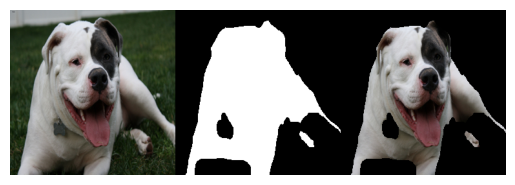

In [8]:
plt.axis('off')  # Tắt hiển thị trục tọa độ
img = x[0]  # Lấy ảnh đầu tiên từ batch dữ liệu x
msk = y[0].squeeze()  # Lấy mask tương ứng với ảnh đầu tiên và loại bỏ các chiều có kích thước bằng 1
msk = np.stack((msk,)*3, axis=-1)  # Sao chép mask thành 3 kênh màu (RGB) để hiển thị dưới dạng ảnh màu

# Nối 3 ảnh: ảnh gốc, mask, và ảnh được phân đoạn (ảnh gốc * mask) theo chiều ngang
# axis=1 để nối theo chiều ngang
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))
plt.show()  # Hiển thị ảnh đã nối

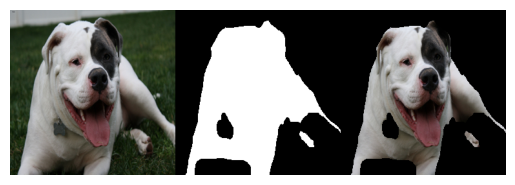

In [9]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

Chỉ số IoU

Chỉ số giao điểm trên hợp nhất (Intersection over Union - IoU) là một chỉ số đơn giản được sử dụng để đánh giá hiệu suất của một thuật toán phân đoạn. Cho hai mặt nạ (mask) y_true (mặt nạ thực) và y_pred (mặt nạ dự đoán), chúng ta đánh giá IoU như sau:
Giải thích:

y_true: Mặt nạ thực, thể hiện nhãn phân đoạn chính xác cho một hình ảnh.
y_pred: Mặt nạ dự đoán, được tạo ra bởi thuật toán phân đoạn.
Giao điểm (∩): Vùng mà cả mặt nạ thực và mặt nạ dự đoán đều xác định là đối tượng.
Hợp nhất (∪): Vùng được bao phủ bởi ít nhất một trong hai mặt nạ (thực hoặc dự đoán).
Công thức IoU:

IoU được tính bằng cách chia diện tích giao điểm cho diện tích hợp nhất của hai mặt nạ.

Ý nghĩa:

IoU càng gần 1, thuật toán phân đoạn càng chính xác.
IoU bằng 1 có nghĩa là mặt nạ dự đoán hoàn toàn trùng khớp với mặt nạ thực.
IoU bằng 0 có nghĩa là không có sự trùng lặp nào giữa mặt nạ dự đoán và mặt nạ thực.

In [35]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]  # Lấy kênh đầu tiên (kênh mask) của y_true (ground truth)
    # yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')  # Chuyển đổi y_pred thành dạng nhị phân (0 hoặc 1) dựa trên ngưỡng 0.5
    yp0 = tf.cast(y_pred[:,:,:,0] > 0.5, 'float32')  # Chuyển đổi y_pred thành dạng nhị phân (0 hoặc 1) dựa trên ngưỡng 0.5
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))  # Tính số lượng pixel giao nhau (cả y_true và y_pred đều bằng 1)
    union = tf.math.count_nonzero(tf.logical_or(tf.equal(yt0, 1), tf.equal(yp0, 1))) # Changed to tf.logical_or
    # union = tf.count_nonzero(tf.add(yt0, yp0))  # Tính số lượng pixel hợp nhất (y_true hoặc y_pred bằng 1)
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))  # Tính IoU, nếu union bằng 0 thì IoU bằng 1, ngược lại IoU = giao nhau / hợp nhất
    return iou  # Trả về giá trị IoU

Giải thích chi tiết hơn:

yt0 = y_true[:,:,:,0]:

y_true là tensor chứa ground truth (nhãn thực tế) của ảnh.
[:,:,:,0] lấy tất cả các giá trị trên 3 chiều đầu tiên và chỉ lấy kênh đầu tiên (kênh 0) trên chiều cuối cùng. Kênh này thường đại diện cho mask của đối tượng.
Kết quả được gán cho biến yt0, đại diện cho mask ground truth.
yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32'):

y_pred là tensor chứa kết quả dự đoán của mô hình.
[:,:,:,0] tương tự như trên, lấy kênh đầu tiên (kênh mask) của y_pred.
y_pred[:,:,:,0] > 0.5 so sánh các giá trị trong kênh mask với ngưỡng 0.5. Nếu giá trị lớn hơn 0.5, kết quả là True (1), ngược lại là False (0).
K.cast(..., 'float32') chuyển đổi kết quả sang kiểu dữ liệu float32.
Kết quả được gán cho biến yp0, đại diện cho mask dự đoán ở dạng nhị phân.
inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1))):

tf.equal(yt0, 1) tạo ra một tensor với các giá trị True (1) ở những vị trí yt0 bằng 1 (pixel thuộc đối tượng trong ground truth), ngược lại là False (0).
tf.equal(yp0, 1) tương tự, tạo ra một tensor với các giá trị True (1) ở những vị trí yp0 bằng 1 (pixel thuộc đối tượng trong dự đoán), ngược lại là False (0).
tf.logical_and(...) thực hiện phép AND logic giữa hai tensor trên. Kết quả là một tensor với các giá trị True (1) chỉ ở những vị trí cả hai tensor đều bằng 1 (pixel thuộc đối tượng trong cả ground truth và dự đoán), ngược lại là False (0).
tf.count_nonzero(...) đếm số lượng giá trị khác 0 (tức là True) trong tensor kết quả. Đây chính là số lượng pixel giao nhau giữa ground truth và dự đoán.
Kết quả được gán cho biến inter.
union = tf.count_nonzero(tf.add(yt0, yp0)):

tf.add(yt0, yp0) cộng hai tensor yt0 và yp0. Kết quả là một tensor với các giá trị:
0: nếu cả yt0 và yp0 đều bằng 0 (pixel không thuộc đối tượng trong cả ground truth và dự đoán).
1: nếu chỉ một trong hai yt0 hoặc yp0 bằng 1 (pixel thuộc đối tượng trong ground truth hoặc dự đoán).
2: nếu cả yt0 và yp0 đều bằng 1 (pixel thuộc đối tượng trong cả ground truth và dự đoán).
tf.count_nonzero(...) đếm số lượng giá trị khác 0 trong tensor kết quả. Đây chính là số lượng pixel hợp nhất giữa ground truth và dự đoán.
Kết quả được gán cho biến union.
iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32')):

tf.equal(union, 0) kiểm tra xem union có bằng 0 hay không.
tf.where(...) là một hàm điều kiện. Nếu union bằng 0 (trường hợp không có pixel nào trùng nhau), thì IoU được gán bằng 1.
Ngược lại, IoU được tính bằng inter/union và chuyển đổi sang kiểu dữ liệu float32.
Kết quả được gán cho biến iou.
return iou: Trả về giá trị IoU đã tính được.

# Model

In [36]:
def unet(sz = (256, 256, 3)):  # Định nghĩa hàm unet, nhận đầu vào là kích thước ảnh sz (mặc định là 256x256x3)
  x = Input(sz)  # Tạo một layer Input, nhận đầu vào là tensor có kích thước sz
  inputs = x  # Lưu layer Input vào biến inputs để sử dụng sau này khi tạo model

  # --- Down sampling (Giai đoạn mã hóa) ---
  f = 8  # Khởi tạo số lượng filter ban đầu là 8
  layers = []  # Khởi tạo một list rỗng để lưu trữ các layer trong quá trình down sampling

  for i in range(0, 6):  # Lặp 6 lần để tạo 6 block down sampling
    x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D với f filter, kernel size 3x3, activation function là relu, padding là 'same'
    x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D tương tự như trên
    layers.append(x)  # Lưu layer hiện tại vào list layers
    x = MaxPooling2D() (x)  # Thêm một lớp Max Pooling 2D để giảm kích thước feature map
    f = f*2  # Tăng gấp đôi số lượng filter cho block tiếp theo

  ff2 = 64  # Khởi tạo số lượng filter cho lớp Conv2DTranspose đầu tiên trong giai đoạn upsampling

  # --- Bottleneck (Giai đoạn kết nối) ---
  j = len(layers) - 1  # Lấy index của layer cuối cùng trong list layers
  x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
  x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)  # Thêm một lớp Conv2DTranspose để tăng kích thước feature map
  x = Concatenate(axis=3)([x, layers[j]])  # Nối layer hiện tại với layer tương ứng trong list layers (skip connection)
  j = j -1  # Giảm index j để chuẩn bị cho lần lặp tiếp theo

  # --- Upsampling (Giai đoạn giải mã) ---
  for i in range(0, 5):  # Lặp 5 lần để tạo 5 block upsampling
    ff2 = ff2//2  # Giảm một nửa số lượng filter cho lớp Conv2DTranspose tiếp theo
    f = f // 2  # Giảm một nửa số lượng filter cho lớp Conv2D tiếp theo
    x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
    x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)  # Thêm một lớp Conv2DTranspose để tăng kích thước feature map
    x = Concatenate(axis=3)([x, layers[j]])  # Nối layer hiện tại với layer tương ứng trong list layers (skip connection)
    j = j -1  # Giảm index j để chuẩn bị cho lần lặp tiếp theo

  # --- Classification (Giai đoạn phân loại) ---
  x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
  x = Conv2D(f, 3, activation='relu', padding='same') (x)  # Thêm một lớp Convolutional 2D
  outputs = Conv2D(1, 1, activation='sigmoid') (x)  # Thêm một lớp Convolutional 2D với 1 filter, kernel size 1x1, activation function là sigmoid để tạo ra output cuối cùng

  # --- Model creation (Tạo model) ---
  model = Model(inputs=[inputs], outputs=[outputs])  # Tạo model Keras từ layer Input (inputs) và layer Output (outputs)
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])  # Compile model với optimizer là rmsprop, loss function là binary_crossentropy, và metric là mean_iou

  return model  # Trả về model đã tạo

In [37]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions

In [38]:
def build_callbacks():
    checkpointer = ModelCheckpoint(filepath='unet.weights.h5', verbose=0, save_best_only=True, save_weights_only=True)  # Tạo một callback ModelCheckpoint để lưu model tốt nhất
    # filepath: Đường dẫn lưu model, 'unet.h5'
    # verbose: 0 - không in thông tin, 1 - in thông tin khi lưu model
    # save_best_only: True - chỉ lưu model tốt nhất, False - lưu model sau mỗi epoch
    # save_weights_only: True - chỉ lưu trọng số của model, False - lưu toàn bộ model
    callbacks = [checkpointer, PlotLearning()]  # Tạo một list callbacks chứa ModelCheckpoint và PlotLearning
    return callbacks  # Trả về list callbacks


# Kế thừa từ keras.callbacks.Callback để tạo một callback tùy chỉnh
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):  # Hàm được gọi khi quá trình huấn luyện bắt đầu
        self.i = 0  # Khởi tạo biến i (số epoch) bằng 0
        self.x = []  # Khởi tạo list x để lưu trữ số epoch
        self.losses = []  # Khởi tạo list losses để lưu trữ giá trị loss
        self.val_losses = []  # Khởi tạo list val_losses để lưu trữ giá trị validation loss
        self.acc = []  # Khởi tạo list acc để lưu trữ giá trị accuracy (mean_iou)
        self.val_acc = []  # Khởi tạo list val_acc để lưu trữ giá trị validation accuracy (val_mean_iou)
        #self.fig = plt.figure()  # Khởi tạo một figure để vẽ biểu đồ (đã bị comment)
        self.logs = []  # Khởi tạo list logs để lưu trữ logs

    def on_epoch_end(self, epoch, logs={}):  # Hàm được gọi khi kết thúc mỗi epoch
        logs = logs or {} # If logs is None, replace it with an empty dictionary.
        self.logs.append(logs)  # Thêm logs vào list logs
        self.x.append(self.i)  # Thêm số epoch vào list x
        self.losses.append(logs.get('loss'))  # Thêm giá trị loss vào list losses
        self.val_losses.append(logs.get('val_loss'))  # Thêm giá trị validation loss vào list val_losses
        self.acc.append(logs.get('mean_iou'))  # Thêm giá trị accuracy vào list acc
        self.val_acc.append(logs.get('val_mean_iou'))  # Thêm giá trị validation accuracy vào list val_acc
        self.i += 1  # Tăng số epoch lên 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))  # In thông tin về loss, accuracy

        # Chọn một ảnh ngẫu nhiên từ tập test và tiền xử lý
        path = np.random.choice(test_files)  # Chọn ngẫu nhiên một đường dẫn ảnh từ test_files
        raw = Image.open(f'images/{path}')  # Mở ảnh bằng PIL
        raw = np.array(raw.resize((256, 256)))/255.  # Resize ảnh về 256x256 và chuyển đổi thành mảng numpy, sau đó chuẩn hóa về [0, 1]
        raw = raw[:,:,0:3]  # Lấy 3 kênh màu đầu tiên (RGB) của ảnh

        # Dự đoán mask
        pred = model.predict(np.expand_dims(raw, 0))  # Dự đoán mask bằng model, thêm chiều batch (0) cho ảnh đầu vào

        # Hậu xử lý mask
        msk  = pred.squeeze()  # Loại bỏ chiều batch của mask dự đoán
        msk = np.stack((msk,)*3, axis=-1)  # Sao chép mask thành 3 kênh màu (RGB)
        msk[msk >= 0.5] = 1  # Gán giá trị 1 cho các pixel có giá trị >= 0.5 (đối tượng)
        msk[msk < 0.5] = 0  # Gán giá trị 0 cho các pixel có giá trị < 0.5 (nền)

        # Hiển thị mask và ảnh phân đoạn
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)  # Nối ảnh gốc, mask, và ảnh phân đoạn theo chiều ngang
        plt.axis('off')  # Tắt hiển thị trục tọa độ
        plt.imshow(combined)  # Hiển thị ảnh đã nối
        plt.show()  # Hiển thị biểu đồ

# Training

i= 1 loss= 0.567823588848114 val_loss= 0.5003576278686523 mean_iou= 0.0035481119994074106 val_mean_iou= 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


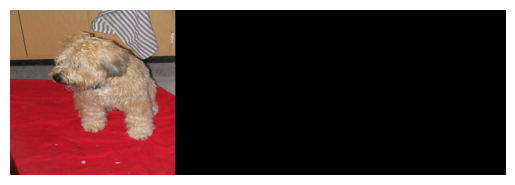

i= 2 loss= 0.48809880018234253 val_loss= 0.4565052092075348 mean_iou= 0.2889758050441742 val_mean_iou= 0.4899177849292755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


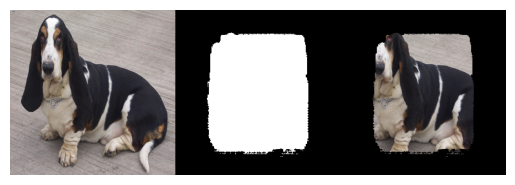

i= 3 loss= 0.4425765872001648 val_loss= 0.42924296855926514 mean_iou= 0.4540495276451111 val_mean_iou= 0.38837650418281555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


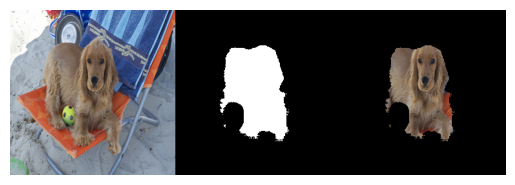

i= 4 loss= 0.4201642870903015 val_loss= 0.5472691059112549 mean_iou= 0.47468626499176025 val_mean_iou= 0.1337548941373825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


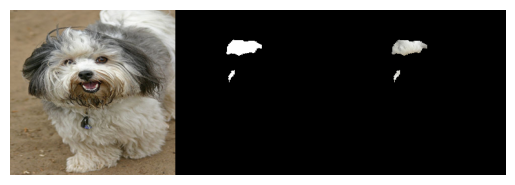

i= 5 loss= 0.3953515291213989 val_loss= 0.401321142911911 mean_iou= 0.5060318112373352 val_mean_iou= 0.4590057134628296
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


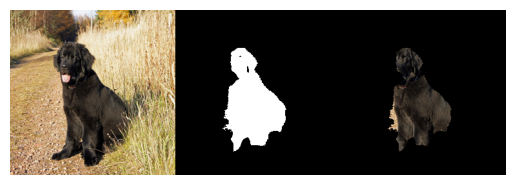

i= 6 loss= 0.37270742654800415 val_loss= 0.3438178300857544 mean_iou= 0.5482444167137146 val_mean_iou= 0.5703430771827698
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


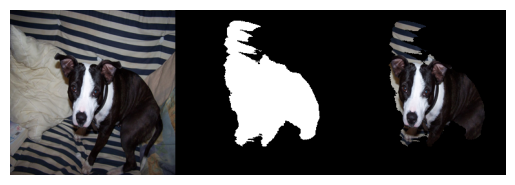

i= 7 loss= 0.3379080891609192 val_loss= 0.3174760639667511 mean_iou= 0.5935437679290771 val_mean_iou= 0.5887272357940674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


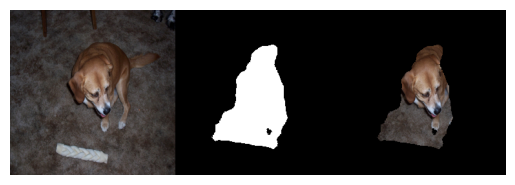

i= 8 loss= 0.3136167824268341 val_loss= 0.28839796781539917 mean_iou= 0.6232852339744568 val_mean_iou= 0.6488977074623108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


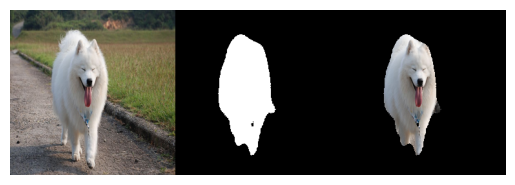

i= 9 loss= 0.28655803203582764 val_loss= 0.2774316072463989 mean_iou= 0.6541466116905212 val_mean_iou= 0.648821234703064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


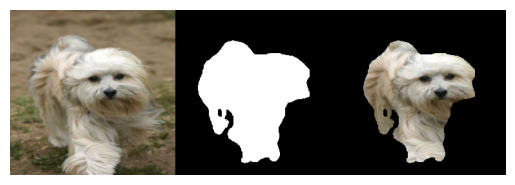

i= 10 loss= 0.2683942914009094 val_loss= 0.2607363760471344 mean_iou= 0.6799509525299072 val_mean_iou= 0.6862378716468811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


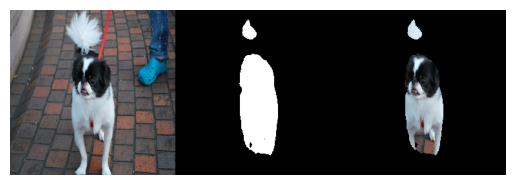

i= 11 loss= 0.2505476474761963 val_loss= 0.2553679347038269 mean_iou= 0.6966832280158997 val_mean_iou= 0.6828572154045105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


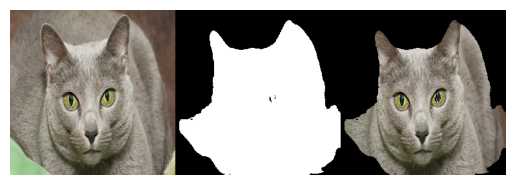

i= 12 loss= 0.23581530153751373 val_loss= 0.27411919832229614 mean_iou= 0.7163974046707153 val_mean_iou= 0.6920070648193359
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


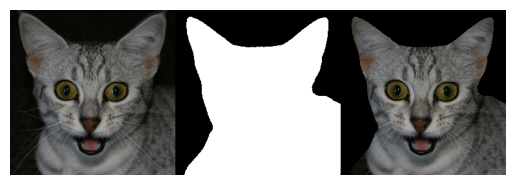

i= 13 loss= 0.22379200160503387 val_loss= 0.21794743835926056 mean_iou= 0.7301419973373413 val_mean_iou= 0.7266433835029602
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


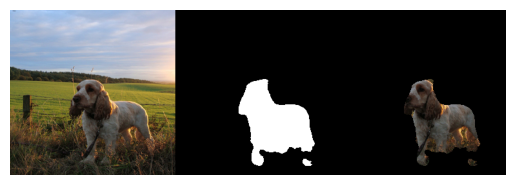

i= 14 loss= 0.21345959603786469 val_loss= 0.20498833060264587 mean_iou= 0.745265543460846 val_mean_iou= 0.7381477355957031
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


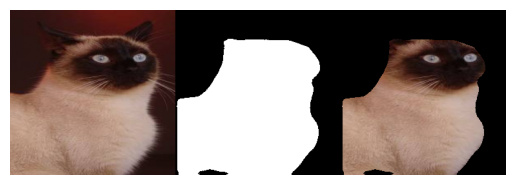

i= 15 loss= 0.20219989120960236 val_loss= 0.20524217188358307 mean_iou= 0.7537822723388672 val_mean_iou= 0.7397375106811523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


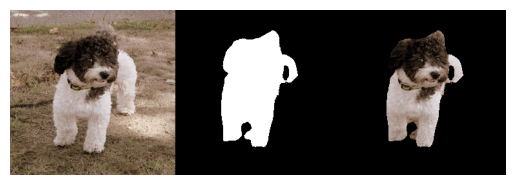

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2019-01-05 15:38:20--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 52.85.158.141, 52.85.158.126, 52.85.158.204, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|52.85.158.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63220 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K   127KB/s    in 0.5s    

2019-01-05 15:38:21 (127 KB/s) - ‘test.jpg’ saved [63220/63220]



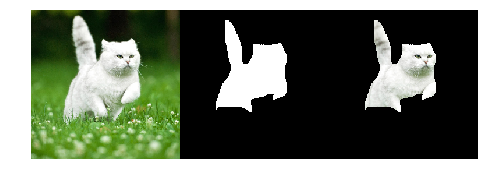

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

